<a href="https://colab.research.google.com/github/isabellacadisco/Algorithms-for-Massive-Data-course/blob/main/AMD_Cadisco_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
#set up os env
os.environ['KAGGLE_USERNAME'] = "XXXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXX"

# download dataset from kaggle and save it in drive
!kaggle datasets download -d xhlulu/medal-emnlp

100% 6.82G/6.82G [02:13<00:00, 24.6MB/s]
100% 6.82G/6.82G [02:13<00:00, 54.8MB/s]


In [2]:
!unzip medal-emnlp.zip #unzip dataset

Archive:  medal-emnlp.zip
  inflating: full_data.csv           
  inflating: pretrain_subset/test.csv  
  inflating: pretrain_subset/train.csv  
  inflating: pretrain_subset/valid.csv  


In [36]:
# set up spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #install java as VM
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz #download Spark
!tar xf spark-3.4.0-bin-hadoop3.tgz #unzip the file
!pip install -q findspark

#boh
!pip install pyspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"


import findspark
findspark.init("spark-3.4.0-bin-hadoop3")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() #SPARK SESSION

import pyspark
type(spark)

pyspark.sql.session.SparkSession

In [39]:
file_path = './full_data.csv'

In [40]:
data = spark.read.csv(file_path, header=True)

In [41]:
# withReplacement=True to (maybe) create duplicates which could be detected
small_data = data.sample(withReplacement=True, fraction=0.00007, seed=42)

In [42]:
from pyspark.sql.functions import monotonically_increasing_id

In [44]:
dataset = small_data.select('TEXT', 'LABEL').withColumn('doc_id', monotonically_increasing_id())

In [49]:
dataset.show()

+--------------------+--------------------+----------+
|                TEXT|               LABEL|    doc_id|
+--------------------+--------------------+----------+
|by sequential aci...|gel filtration|ph...|         0|
|two case reports ...|parotid gland|sal...|         1|
|because the pancr...|total parenteral ...|         2|
|rat brain SSA des...|succinic semialde...|         3|
|the physiological...|central|general|m...|         4|
|we have studied f...|             history|         5|
|exercise tests wi...|ischemic|heart|ac...|         6|
|the concentration...|serum|liver|homog...|8589934592|
|the authors repor...|side effects|onse...|8589934593|
|ocular movement w...|parkinsons diseas...|8589934594|
|in order to evalu...|           detection|8589934595|
|the characteristi...|           detection|8589934596|
|to determine the ...|specific|injectio...|8589934597|
|we studied a seri...|development|speci...|8589934598|
|we assessed the a...|glucose|errors|gl...|8589934599|
|two metho

# Text preprocessing

In [11]:
%%capture
!pip install spacy
!python -m spacy download en_core_web_sm

In [12]:
# Import spaCy and download the English model
import spacy
import en_core_web_sm

# Load the spaCy English model FORSE NON SERVE BOH
nlp = en_core_web_sm.load()

import string

In [13]:
def preprocess_text(text):
    # Initialize spaCy resources
    nlp = spacy.load("en_core_web_sm")

    # Apply spaCy NLP pipeline
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.text not in string.punctuation]

    # Join tokens back into a text
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [14]:
# UDF --

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Register the UDF with Spark
preprocess_udf_spark = udf(preprocess_text, StringType())

In [50]:
df_prepr = dataset.withColumn("preprocessed_text", preprocess_udf_spark(dataset['TEXT']))

In [51]:
df_prepr.show()

+--------------------+--------------------+----------+--------------------+
|                TEXT|               LABEL|    doc_id|   preprocessed_text|
+--------------------+--------------------+----------+--------------------+
|by sequential aci...|gel filtration|ph...|         0|sequential acid t...|
|two case reports ...|parotid gland|sal...|         1|case report pure ...|
|because the pancr...|total parenteral ...|         2|pancrea undergo i...|
|rat brain SSA des...|succinic semialde...|         3|rat brain ssa des...|
|the physiological...|central|general|m...|         4|physiological eff...|
|we have studied f...|             history|         5|study unrelated m...|
|exercise tests wi...|ischemic|heart|ac...|         6|exercise test bic...|
|the concentration...|serum|liver|homog...|8589934592|concentration som...|
|the authors repor...|side effects|onse...|8589934593|author report cas...|
|ocular movement w...|parkinsons diseas...|8589934594|ocular movement s...|
|in order to

# Shingling

In [52]:
# create new dataframe w/ just doc_id, preprocessed_text

df = df_prepr.select("doc_id", "preprocessed_text")

In [53]:
df.show()

+----------+--------------------+
|    doc_id|   preprocessed_text|
+----------+--------------------+
|         0|sequential acid t...|
|         1|case report pure ...|
|         2|pancrea undergo i...|
|         3|rat brain ssa des...|
|         4|physiological eff...|
|         5|study unrelated m...|
|         6|exercise test bic...|
|8589934592|concentration som...|
|8589934593|author report cas...|
|8589934594|ocular movement s...|
|8589934595|order evaluate re...|
|8589934596|characteristic he...|
|8589934597|determine relativ...|
|8589934598|study series eye ...|
|8589934599|assess analytical...|
|8589934600|method assay seru...|
|8589934601|hypercalcaemic hy...|
|8589934602|ultrastructural d...|
|8589934603|conscientious pre...|
|8589934604|simple timecycle ...|
+----------+--------------------+
only showing top 20 rows



In [19]:
print(20**5, 2**16, 2**32)

3200000 65536 4294967296


In [20]:
# per ora mi tengo k = 5 che ha senso per tipo di doc anche se non trovo roba e hasho su
# 4 byte anche se sono molti di più, lo uso solo per mappare a numeri

In [54]:
def get_shingles(text, k):
    shingles = set()
    for i in range(0, len(text)-k+1 ):
        shingles.add(text[i:i+k])
    return list(shingles)

In [55]:
shingled_rdd = df.rdd.map(lambda x : (x[0], get_shingles(x[1], 5)))

In [56]:
shingled_rdd.toDF().show()

+----------+--------------------+
|        _1|                  _2|
+----------+--------------------+
|         0|[gh te, n hig, em...|
|         1|[logic,  comp, ss...|
|         2|[ily c, mm un, la...|
|         3|[ fatt, se ac, ip...|
|         4|[consc, the s, ve...|
|         5|[ted m, n ava, et...|
|         6|[ho he, lay m, le...|
|8589934592|[ rat ,  tiss, ea...|
|8589934593|[cal s, logic, ib...|
|8589934594|[ sacc, ease , ar...|
|8589934595|[de ip, y gre, l ...|
|8589934596|[fecti, runca, es...|
|8589934597|[ifera, n hig,  r...|
|8589934598|[ease , tpron, ic...|
|8589934599|[ce co, nicon, ep...|
|8589934600|[der a, ense , ai...|
|8589934601|[al fa, cal s, ea...|
|8589934602|[cal s,  squi, yt...|
|8589934603|[consc, cal s, sl...|
|8589934604|[ntila, n sim, n ...|
+----------+--------------------+
only showing top 20 rows



In [57]:
# CLASS HASH FAMILY

import re, hashlib, math, time
from random import randint, seed

# scoprire esattamente a cosa serve
seed(16)

class hashFamily:
    def __init__(self, i):
        self.resultSize = 4 # how many bytes we want back
        self.maxLen = 20 # how long can our i be (in decimal)
        self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]
        self.id = i

    def get_hash_value(self, el_to_hash):
        return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16)


In [62]:
h_f = hashFamily(5)

print("ciao: ", h_f.get_hash_value("ciao"), ", ", "ciao", h_f.get_hash_value("ciao"))

ciao:  32651 ,  ciao 32651


In [58]:
# Hash shingles

def get_hashed_shingles(shingles_set):
  hash_func = hashFamily(0)
  return sorted({hash_func.get_hash_value(s) for s in set(shingles_set)})

In [59]:
hashed_shingles_rdd = shingled_rdd.map(lambda x: (x[0], get_hashed_shingles(x[1])))

In [60]:
hashed_shingles_rdd.toDF().show()

+----------+--------------------+
|        _1|                  _2|
+----------+--------------------+
|         0|[21, 98, 285, 287...|
|         1|[328, 446, 460, 1...|
|         2|[10, 28, 222, 287...|
|         3|[266, 284, 287, 3...|
|         4|[172, 210, 284, 4...|
|         5|[99, 134, 222, 24...|
|         6|[5, 100, 159, 329...|
|8589934592|[382, 525, 540, 6...|
|8589934593|[493, 580, 1260, ...|
|8589934594|[537, 630, 655, 7...|
|8589934595|[446, 550, 668, 7...|
|8589934596|[88, 641, 880, 98...|
|8589934597|[54, 147, 223, 39...|
|8589934598|[238, 444, 655, 7...|
|8589934599|[86, 287, 353, 44...|
|8589934600|[11, 54, 144, 147...|
|8589934601|[5, 42, 48, 210, ...|
|8589934602|[5, 21, 242, 295,...|
|8589934603|[134, 319, 328, 4...|
|8589934604|[60, 147, 446, 56...|
+----------+--------------------+
only showing top 20 rows



# Min Hashing

In [82]:
# Function to replicate each element with a different number
def replicate_element_with_number(element, i):
    doc_id, shingles = element
    return [(doc_id, shingles, j) for j in range(1, i + 1)]

In [83]:
desired_i = 300

In [84]:
docId_shingles_hFunc_rdd  = hashed_shingles_rdd.flatMap(lambda x:
                                                        replicate_element_with_number(x, desired_i))

In [85]:
docId_shingles_hFunc_rdd.toDF().show()

+---+--------------------+---+
| _1|                  _2| _3|
+---+--------------------+---+
|  0|[21, 98, 285, 287...|  1|
|  0|[21, 98, 285, 287...|  2|
|  0|[21, 98, 285, 287...|  3|
|  0|[21, 98, 285, 287...|  4|
|  0|[21, 98, 285, 287...|  5|
|  0|[21, 98, 285, 287...|  6|
|  0|[21, 98, 285, 287...|  7|
|  0|[21, 98, 285, 287...|  8|
|  0|[21, 98, 285, 287...|  9|
|  0|[21, 98, 285, 287...| 10|
|  0|[21, 98, 285, 287...| 11|
|  0|[21, 98, 285, 287...| 12|
|  0|[21, 98, 285, 287...| 13|
|  0|[21, 98, 285, 287...| 14|
|  0|[21, 98, 285, 287...| 15|
|  0|[21, 98, 285, 287...| 16|
|  0|[21, 98, 285, 287...| 17|
|  0|[21, 98, 285, 287...| 18|
|  0|[21, 98, 285, 287...| 19|
|  0|[21, 98, 285, 287...| 20|
+---+--------------------+---+
only showing top 20 rows



In [86]:
hashed_shingles_rdd.count()

986

In [87]:
docId_shingles_hFunc_rdd.count()

295800

verifica riuscita
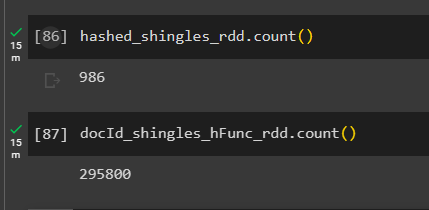

In [88]:
def minhash_map(docId_ShingleSet_hFunct):
    doc_id = docId_ShingleSet_hFunct[0]
    shingles = docId_ShingleSet_hFunct[1]
    hash_f = hashFamily( docId_ShingleSet_hFunct[2] )
    min_h = math.inf
    for el in shingles:
        hash_value = hash_f.get_hash_value(el)
        if hash_value < min_h:
            min_h = hash_value

    return (doc_id, min_h )

In [89]:
sig_matrix = docId_shingles_hFunc_rdd.map(minhash_map).groupByKey().map(lambda x : (x[0], list(x[1])))

In [90]:
sig_matrix.toDF().show()

+------------+--------------------+
|          _1|                  _2|
+------------+--------------------+
|           0|[397, 137, 417, 6...|
| 60129542146|[77, 383, 36, 5, ...|
|120259084292|[35, 346, 74, 287...|
|180388626438|[35, 26, 47, 5, 6...|
|240518168584|[1332, 1440, 383,...|
|420906795022|[39, 123, 66, 25,...|
|515396075521|[46, 95, 137, 25,...|
|575525617667|[17, 105, 66, 82,...|
|635655159813|[39, 26, 284, 220...|
|695784701959|[97, 21, 44, 537,...|
|           1|[121, 738, 494, 2...|
| 60129542147|[179, 21, 11, 105...|
|120259084293|[47, 492, 243, 15...|
|180388626439|[73, 160, 243, 5,...|
|240518168585|[5, 35, 74, 25, 5...|
|455266533376|[97, 1428, 44, 55...|
|515396075522|[97, 53, 47, 25, ...|
|575525617668|[1315, 224, 33, 5...|
|635655159814|[380, 21, 22, 13,...|
|695784701960|[52, 21, 74, 91, ...|
+------------+--------------------+
only showing top 20 rows



# LSH

## Banding technique: b and r choice

In [91]:
from scipy.optimize import fsolve

# Define a function that represents the system of equations
def equations(vars):
    b, r = vars
    eq1 = 0.7 - ((1 / b) ** (1 / r))
    eq2 = b * r - 300
    return [eq1, eq2]

# Initial guess for the solution
initial_guess = [1.0, 1.0]  # You can change these initial values

# Solve the system of equations
result = fsolve(equations, initial_guess)

# Extract the values of b and r from the result
b_solution, r_solution = result

# Print the solutions
print(f"Approximate b: {b_solution}")
print(f"Approximate r: {r_solution}")


Approximate b: 31.123733607951603
Approximate r: 9.638946399547725


In [92]:
b = 30
r = 10

t = ((1 / b) ** (1 / r))

print("My threshold to be candidate: ", t)

My threshold to be candidate:  0.7116851017915987


## Map docs to buckets

In [93]:
def map_buckets(row):

    band_nr = 30
    row_nr = 10
    doc_id = row[0]
    doc_sign = row[1]
    hash_funct = hashFamily(1)
    out = []

    for i in range(0,band_nr):
        band_id = i
        idx = i*row_nr
        set_col = ' '.join(str(x) for x in doc_sign[idx:idx+row_nr])
        bucket = hash_funct.get_hash_value(set_col)
        out.append( ( (band_id, bucket), doc_id)  )

    return iter(out) #since we are going to return multiple tuple we call flatMap() and return an iterator on those tuple


In [94]:
candidates = sig_matrix.flatMap(map_buckets).groupByKey().map(lambda x : (x[0], list(x[1])))

## Generate candidate pairs

In [95]:
from itertools import combinations

In [96]:
def generate_pairs(rdd):
    # Function to generate pairs from a list while considering (a, b) the same as (b, a)
    def generate_unique_pairs(values):
        pairs = list(combinations(values, 2))
        #sorted_pairs = [tuple(sorted(pair)) for pair in pairs]
        return pairs

    # Generate pairs for each row
    pairs_rdd = rdd.flatMap(lambda row: generate_unique_pairs(row[1]))

    # Collect all pairs and deduplicate them
    unique_pairs = pairs_rdd.collect()
    unique_pairs = list(set(unique_pairs))

    return unique_pairs

In [97]:
unique_pairs = generate_pairs(candidates)

In [98]:
len(unique_pairs)

254

In [99]:
print(unique_pairs)

[(944892805125, 438086664198), (412316860416, 266287972355), (335007449094, 25769803779), (197568495616, 326417514498), (343597383681, 412316860418), (446676598787, 962072674310), (420906795022, 369367187460), (867583393792, 867583393795), (94489280512, 781684047877), (429496729605, 463856467970), (214748364804, 807453851649), (317827579912, 111669149700), (283467841541, 42949672968), (515396075529, 558345748481), (283467841540, 352187318283), (352187318274, 652835029004), (867583393795, 936302870531), (352187318274, 627065225228), (575525617670, 8589934596), (395136991235, 738734374912), (188978561030, 523986010115), (128849018880, 377957122048), (515396075521, 652835029002), (42949672961, 936302870532), (300647710722, 695784701958), (463856467970, 317827579904), (188978561031, 463856467969), (214748364800, 549755813892), (386547056640, 635655159810), (824633720834, 652835029005), (523986010113, 652835028992), (274877906951, 858993459200), (944892805120, 51539607553), (609885356033, 7

In [100]:
# docs in candidate pairs

# Flatten the list and get unique values
candidate_docs = set(item for sublist in unique_pairs for item in sublist)

In [143]:
len(candidate_docs)

398

In [146]:
print(candidate_docs)

{412316860416, 197568495616, 326417514498, 266287972355, 25769803779, 944892805125, 438086664198, 335007449094, 343597383681, 412316860418, 446676598787, 962072674310, 369367187460, 867583393792, 420906795022, 94489280512, 867583393795, 463856467970, 515396075529, 352187318283, 352187318274, 214748364804, 111669149700, 283467841540, 936302870531, 8589934596, 429496729605, 781684047877, 283467841541, 936302870532, 549755813892, 317827579904, 807453851649, 558345748481, 575525617670, 738734374912, 188978561030, 128849018880, 377957122048, 515396075521, 42949672961, 317827579912, 42949672968, 188978561031, 274877906951, 77309411336, 661424963592, 652835029000, 618475290633, 652835029001, 412316860424, 652835029002, 154618822666, 644245094410, 661424963593, 8589934602, 300647710722, 635655159810, 824633720834, 17179869186, 764504178690, 652835029004, 627065225228, 901943132162, 833223655426, 17179869196, 652835029005, 17179869197, 146028888076, 240518168588, 146028888065, 901943132161, 618

# Approximate Jaccard similarity
from signature matrix

## Retrieve portion of sig_matrix corresponding to candidate pairs

In [103]:
filtered_sig_m_rdd = sig_matrix.filter(lambda x: x[0] in candidate_docs)

In [109]:
import pandas as pd

In [108]:
to_convert_pd = filtered_sig_m_rdd.collect()

In [110]:
sig_m_filtered_pd = pd.DataFrame(to_convert_pd, columns=["doc_id", "min_hash_values"])

In [122]:
sig_m_filtered_pd

,doc_id,min_hash_values
0,0,"[397, 137, 417, 63, 75, 105, 163, 63, 95, 164,..."
1,420906795022,"[39, 123, 66, 25, 7, 35, 74, 98, 82, 207, 338,..."
2,515396075521,"[46, 95, 137, 25, 21, 178, 16, 476, 46, 2, 138..."
3,695784701959,"[97, 21, 44, 537, 478, 637, 840, 417, 114, 2, ..."
4,120259084293,"[47, 492, 243, 159, 33, 47, 9, 131, 26, 103, 2..."
...,...,...
393,360777252875,"[163, 190, 227, 185, 152, 68, 140, 146, 95, 2,..."
394,575525617666,"[52, 949, 329, 308, 328, 120, 9, 481, 6, 229, ..."
395,635655159812,"[10, 23, 155, 308, 122, 894, 29, 51, 231, 32, ..."
396,695784701958,"[52, 583, 243, 162, 372, 282, 17, 144, 118, 95..."


In [113]:
sig_m_filtered_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_id           398 non-null    int64 
 1   min_hash_values  398 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


In [114]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [116]:
!ls

drive		 pretrain_subset     spark-3.4.0-bin-hadoop3
full_data.csv	 sample_data	     spark-3.4.0-bin-hadoop3.tgz
medal-emnlp.zip  sig_mat_candidates  spark-3.4.0-bin-hadoop3.tgz.1


In [119]:
!cd MyDrive

In [120]:
!ls

MyDrive


In [124]:
sig_m_filtered_pd.to_csv("MyDrive/sig_mat_candidates", index = False)

In [125]:
small_data_pd = df_prepr.toPandas()

In [126]:
small_data_pd

,TEXT,LABEL,doc_id,preprocessed_text
0,by sequential acid treatment GF and kmcellulos...,gel filtration|phosphate buffer|activated,0,sequential acid treatment gf kmcellulose sorpt...
1,two case reports of pure cystic acinic cell ca...,parotid gland|salivary gland,1,case report pure cystic acinic cell carcinoma ...
2,because the pancreas undergoes involutional ch...,total parenteral nutrition|alone|secretin|alone,2,pancrea undergo involutional change tpn tpn pa...
3,rat brain SSA deshydrogenase has been purified...,succinic semialdehyde|succinic semialdehyde,3,rat brain ssa deshydrogenase purify fold enzym...
4,the physiological effects on mammals of elevat...,central|general|model|homologous,4,physiological effect mammal elevated pressure ...
...,...,...,...,...
981,CA therapeuticsrelated cardiac dysfunction ctr...,cancer|mortality rate|detection|strain|sensitive,962072674309,therapeuticsrelate cardiac dysfunction ctrcd l...
982,conventional approaches of implementing comput...,after|model|approach|kinetic energy,962072674310,conventional approach implement computational ...
983,dolichoectasia of the VB artery is a vascular ...,vertebrobasilar,962072674311,dolichoectasia vb artery vascular anomaly char...
984,some eastern asian countries deem pufferfish e...,compounds|compounds,962072674312,eastern asian country deem pufferfish especial...


In [127]:
small_data_pd.to_csv("MyDrive/small_data.csv", index = False)

In [128]:
small_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TEXT               986 non-null    object
 1   LABEL              986 non-null    object
 2   doc_id             986 non-null    int64 
 3   preprocessed_text  986 non-null    object
dtypes: int64(1), object(3)
memory usage: 30.9+ KB


## Jaccard sim approximation computation

In [147]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

In [158]:
# Create an empty list to store data for the new DataFrame
jaccard_data = []

In [160]:
# Assuming candidate_pairs is a list of (doc_id1, doc_id2) pairs
for doc_id1, doc_id2 in unique_pairs:
    # Find the corresponding MinHash values for doc_id1 and doc_id2
    min_hash1 = sig_m_filtered_pd[sig_m_filtered_pd['doc_id'] == doc_id1]['min_hash_values'].values[0]
    min_hash2 = sig_m_filtered_pd[sig_m_filtered_pd['doc_id'] == doc_id2]['min_hash_values'].values[0]

    # Convert the MinHash values to sets
    set1 = set(min_hash1)
    set2 = set(min_hash2)

    # Calculate Jaccard similarity
    similarity = jaccard_similarity(set1, set2)

    # Append the data as a dictionary to the list
    jaccard_data.append({'doc_id1': doc_id1, 'doc_id2': doc_id2, 'jaccard_similarity': similarity})


In [203]:
jaccard_data[45]

{'doc_id1': 644245094403,
 'doc_id2': 352187318279,
 'jaccard_similarity': 0.16310160427807488}

In [179]:
type(jaccard_data[0])

dict

In [162]:
len(jaccard_data)

254

In [163]:
len(unique_pairs)

254

In [164]:

# Create the new DataFrame using pd.DataFrame
jaccard_df = pd.DataFrame(jaccard_data)


In [165]:
jaccard_df

,doc_id1,doc_id2,jaccard_similarity
0,944892805125,438086664198,0.226776
1,412316860416,266287972355,0.350806
2,335007449094,25769803779,0.341549
3,197568495616,326417514498,0.402985
4,343597383681,412316860418,0.417062
...,...,...,...
249,807453851652,85899345923,0.296178
250,335007449091,575525617664,0.388889
251,249108103171,618475290632,0.252907
252,395136991237,42949672968,0.254601


In [166]:
# Sort the DataFrame by 'jaccard_similarity' column in descending order
sorted_jaccard_df = jaccard_df.sort_values(by='jaccard_similarity', ascending=False)

# Select the top 20 rows
top_20_similarities = sorted_jaccard_df.head(20)

# Print the top 20 similarities
print(top_20_similarities)


          doc_id1       doc_id2  jaccard_similarity
32   944892805120   51539607553            0.521951
243  670014898182  712964571136            0.510309
182  481036337153  876173328389            0.509804
233  824633720839  627065225219            0.502591
179  893353197569  206158430211            0.500000
70   429496729603  644245094410            0.494845
138  609885356032  300647710723            0.488263
201  549755813891  292057776131            0.485714
6    420906795022  369367187460            0.482927
172  180388626439  919123001348            0.481982
203  429496729605  343597383681            0.475556
71              0  919123001347            0.474178
210  558345748484  317827579914            0.470833
60    34359738370  523986010112            0.468750
217  670014898188  644245094410            0.467980
140  240518168586  893353197570            0.466063
107  773094113287  266287972352            0.465517
62   188978561031  103079215105            0.464789
77   7988639

In [167]:
top_20_similarities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 32 to 34
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   doc_id1             20 non-null     int64  
 1   doc_id2             20 non-null     int64  
 2   jaccard_similarity  20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 640.0 bytes


In [ ]:
#-------------------------------------------------

In [184]:
list_of_dicts = top_20_similarities.to_dict(orient='records')

In [201]:
for item in list_of_dicts:
    doc_id1 = item['doc_id1']
    doc_id2 = item['doc_id2']
    jaccard_similarity = item['jaccard_similarity']

    text_1 = small_data_pd[small_data_pd['doc_id'] == doc_id1]['TEXT'].to_string(index=False)
    text_2 = small_data_pd[small_data_pd['doc_id'] == doc_id2]['TEXT'].to_string(index=False)

    labels_1 = small_data_pd[small_data_pd['doc_id'] == doc_id1]['LABEL'].to_string(index=False)
    labels_2 = small_data_pd[small_data_pd['doc_id'] == doc_id2]['LABEL'].to_string(index=False)


    print("doc id 1: ", doc_id1)
    print("doc id 2: ", doc_id2)

    print("text 1: ", text_1)
    print("text 2: ", text_2)

    print("labels 1: ", labels_1)
    print("labels 2: ", labels_2)


    print("-----------------------------------------")

doc id 1:  944892805120
doc id 2:  51539607553
text 1:  myoepithelial tumours are a rare form of saliva...
text 2:  between january and may six children underwent ...
labels 1:  history|frontal lobe|operation|after|compounds
labels 2:  recovery|after|ventricle|large|ventricular|care...
-----------------------------------------
doc id 1:  670014898182
doc id 2:  712964571136
text 1:  a yr study was conducted using a Ã factorial a...
text 2:  although there is a great deal of stationary ph...
labels 1:  factors|dryrolled corn|after|groups|feeding
labels 2:  development|factors
-----------------------------------------
doc id 1:  481036337153
doc id 2:  876173328389
text 1:  most solid PT display extracellular acidosis wh...
text 2:  the time children spend in childcare overlaps w...
labels 1:  tumors|tumors|tumor|factors|completely
labels 2:  development
-----------------------------------------
doc id 1:  824633720839
doc id 2:  627065225219
text 1:  development of endotoxin tolerance 

In [199]:
small_data_pd

,TEXT,LABEL,doc_id,preprocessed_text
0,by sequential acid treatment GF and kmcellulos...,gel filtration|phosphate buffer|activated,0,sequential acid treatment gf kmcellulose sorpt...
1,two case reports of pure cystic acinic cell ca...,parotid gland|salivary gland,1,case report pure cystic acinic cell carcinoma ...
2,because the pancreas undergoes involutional ch...,total parenteral nutrition|alone|secretin|alone,2,pancrea undergo involutional change tpn tpn pa...
3,rat brain SSA deshydrogenase has been purified...,succinic semialdehyde|succinic semialdehyde,3,rat brain ssa deshydrogenase purify fold enzym...
4,the physiological effects on mammals of elevat...,central|general|model|homologous,4,physiological effect mammal elevated pressure ...
...,...,...,...,...
981,CA therapeuticsrelated cardiac dysfunction ctr...,cancer|mortality rate|detection|strain|sensitive,962072674309,therapeuticsrelate cardiac dysfunction ctrcd l...
982,conventional approaches of implementing comput...,after|model|approach|kinetic energy,962072674310,conventional approach implement computational ...
983,dolichoectasia of the VB artery is a vascular ...,vertebrobasilar,962072674311,dolichoectasia vb artery vascular anomaly char...
984,some eastern asian countries deem pufferfish e...,compounds|compounds,962072674312,eastern asian country deem pufferfish especial...
